# In this notebook we'll look at removing noise from an image using a markov random field

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image


## First we need a noisy image

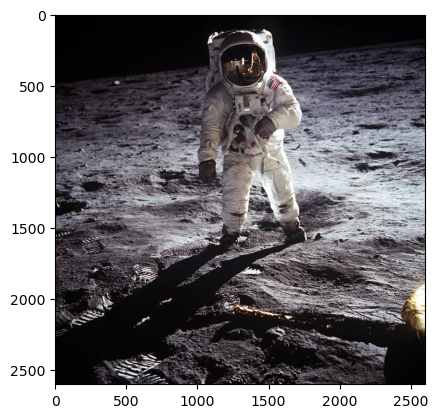

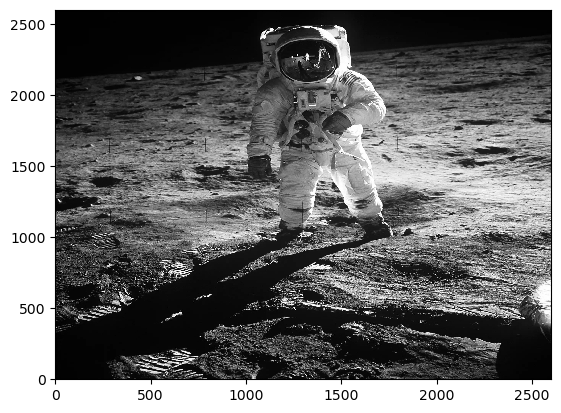

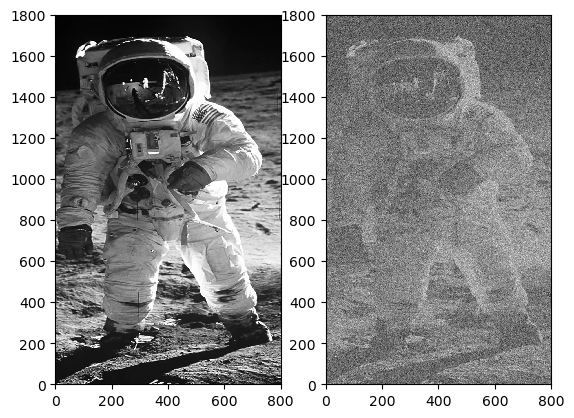

In [3]:
# Load an image of the moon landing
image = np.array(Image.open("./example_pics/Moon.jpg"))
fig, ax = plt.subplots()
ax.imshow(image)

# Average over color channel to make things easier and normilise to 1
image = np.flipud(np.mean(image, axis=2) / 255)
fig, ax = plt.subplots()
ax.pcolormesh(image, cmap="gray")

# Now lets add some gaussian noise (10%)
image_noisy = np.random.normal(image, 0.3)

fig, ax = plt.subplots(1, 2,)
ax[0].pcolormesh(image[800:, 1000:1800], cmap="gray")
ax[1].pcolormesh(image_noisy[800:, 1000:1800], cmap="gray")
plt.show()

# This image is annoyingly large. So lets just crop buzz
image_noisy = image_noisy[800:, 1000:1800]
image = image[800:, 1000:1800]


In [3]:
def log_likeli(x, mu, sigma):
    """
    Gaussian log likelihood
    :param x: Measured pixel counts.
    :param mu: Mean pixel counts
    :param sigma: pixel s.d.
    """
    dist = torch.distributions.normal.Normal(mu, torch.abs(sigma))
    return torch.sum(dist.log_prob(x))

def lorentz(z, sigma):
    """
    Lorentz energy function
    :param z: Pixel difference [y_i - N(y_i)].
    :param sigma: Function hyperparameter.
    """
    return torch.log(1 + 0.5 * (z / sigma) ** 2.0)


def prior(y, sigma):
    """
    Log markov random field prior.
    :param y: Clean pixel values.
    :param sigma: Lorentz function hypreparamter.
    """
    # Here I loop through pixels and compare to surrounding pixels. This is
    # vectorised using torch.unfold(). I ignore the pixels on the edges
    # (i.e. y[1:-1, 1:-1] ) to simplify things as they have less neighbours.
    indices = [0, 1, 2, 3, 5, 6, 7, 8]
    windows = torch.abs(y).unfold(0, 3, 1).unfold(1, 3, 1).flatten(0, 1).flatten(1, 2)
    x_repeat = torch.swapaxes(y[1:-1, 1:-1].repeat(8, 1, 1).flatten(1, 2), 0, 1)
    return torch.sum(lorentz(windows[:, indices] - x_repeat, sigma))

In [4]:
def denoise_MRF(image, sigma, alpha, epochs=10000):
    """
    Main MRF denoising function.
    :param image: Noisy input image
    :param sigma: Lorentz function hypreparamter.
    :param alpha: likelihood vs prior hypreparamter.
    :param epochs: Number of optimiser iterations.
    :return: Clean image
    """

    # Check if GPU can be used (speeds things up a lot!)
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"

    # Define tensors and pass to device
    image = torch.tensor(image).float()
    image = image.to(dev)

    # Initialise clean image as tensor of ones.
    image_clean = torch.ones_like(image).float()
    image_clean.requires_grad = True
    image_clean = image_clean.to(dev)
    
    # Initilise the likelihood s.d.
    like_sigma = torch.tensor([0.3], requires_grad=True, device=dev)

    # Define optimiser and pass params
    optimiser = torch.optim.RMSprop([image_clean])

    # Loop epochs and optimise
    losses = []
    for i in range(epochs):
        optimiser.zero_grad()
        loss = -log_likeli(image, image_clean, like_sigma) + alpha \
               * prior(image_clean, sigma)
        loss.backward()
        optimiser.step()
        losses.append(loss.item())

    return image_clean.detach().cpu().numpy(), like_sigma, losses

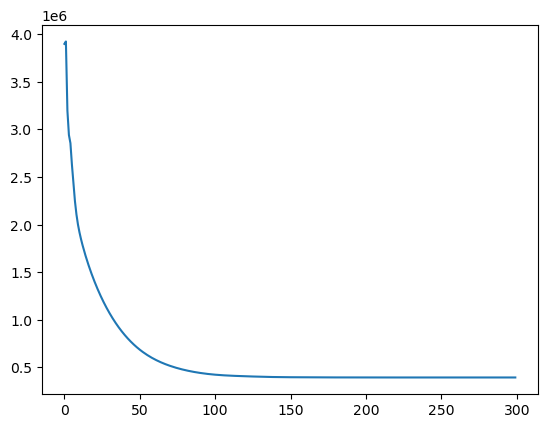

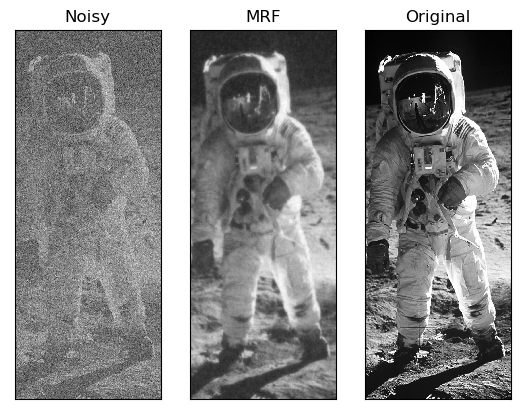

In [5]:
clean_image, like_sigma, loss = denoise_MRF(image_noisy, 0.5, 10, 300)

fig,ax = plt.subplots()
ax.plot(loss)
plt.show()

fig, ax = plt.subplots(1, 3,)
ax[0].pcolormesh(image_noisy, cmap="gray")
ax[0].title.set_text("Noisy")
ax[1].pcolormesh(clean_image, cmap="gray")
ax[1].title.set_text("MRF")
ax[2].pcolormesh(image, cmap="gray")
ax[2].title.set_text("Original")

ax[0].set_xticks([])
ax[0].set_yticks([]) 
ax[1].set_xticks([]) 
ax[1].set_yticks([]) 
ax[2].set_xticks([]) 
ax[2].set_yticks([]) 
plt.show()


In [6]:
### The MRF is definitly not as good as the Original, contrast is worse and a little less detail. However,  it is muich much better than the noise image. Can maybe get better by doining some hyper-paramter optimisation but who has the time.